<a href="https://colab.research.google.com/github/jaybeberry9591/graph_theory_clustering_assignments/blob/main/Metrics_KPrototypes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving crime_boston.csv to crime_boston.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving offense_codes.csv to offense_codes.csv


In [ ]:
import numpy as np
import pandas as pd
from statistics import mode
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import geopandas as gpd
import folium
from folium.plugins import HeatMap

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler

import sklearn.cluster as cluster
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import cluster_optics_dbscan
from sklearn import metrics



In [ ]:
#########################################
############### FUNCTIONS ###############
#########################################

### Data analysis and cleaning
def print_summary(feature): # feature within '' ###################### corrected
    print('Number of unique values: ',df[feature].nunique())
    print(df[feature].dtype)
    print(df[feature].value_counts(dropna = False))
    print('Null values',df[feature].isnull().sum())

def plot_cat_var(df,feature, plot_perc = False,add_mean = False, order = True, palette=None, vertical = False): #df = dataframe; feature within '', plot_perc => Boolean, define_color optional must be within ''; add_mean --> Boolean
    plt.figure(figsize=[20,10])
    plt.title('Number of crimes per ' + feature,  fontsize=20)
    if order == True:
        order= df[feature].value_counts().index
        order = order
    else:
        order = None
    if vertical == False:
        ax = sns.countplot(data = df, x= feature, order = order, palette = palette);
        plt.ylabel('Number of crimes', fontsize=16)
        plt.xlabel('')
        total = len(df)
    else:
        ax = sns.countplot(data = df, y= feature, order = order, palette = palette);
        plt.xlabel('Number of crimes', fontsize=16)
        plt.ylabel('')
    total = len(df)
    if plot_perc == True:
        for p in ax.patches:
            percentage = f'{100 * p.get_height() / total:.1f}%\n'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(percentage, (x, y), rotation=45, annotation_clip=False)
    if add_mean == True:
        ax.axhline(df[feature].value_counts().mean(), 0, label = 'Mean', color = 'red')
        l = plt.legend(loc='upper right')
    return ax

def plot_distr_num_var(feature,nb_bins): # feature within '', nb_bins = for the histogram ###################### corrected
    print(df[feature].describe())
    plt.figure(figsize=[10,5])
    plt.title('Distribution of ' + feature)
    sns.boxplot(data=df, y=feature)
    plt.show()
    plt.figure(figsize=[10,5])
    df[feature].plot(kind='hist', bins = nb_bins)
    plt.figure(figsize=[10,5])
    plt.figure(figsize=[10,5])

def norm_list_values(feature): # feature within ''
    return df[feature].value_counts(normalize=True, dropna=False)*100

def plot_distr_map(df,geo_info, distr_crimes= False): # df --> df to analyse, geo_info: file shp loaded, distr_crimes --> plot distribution of crimes across districts
    geo_info['point'] = geo_info.representative_point() #Returns a GeoSeries of points that are guaranteed to be within each geometry
    label_points = geo_info.copy() # create a copy of geo_info
    label_points.set_geometry('point', inplace = True) # set the district geometry to be the representative point
    if distr_crimes == False:
        ax = geo_info.plot(color = 'lavender', figsize = (30,10), edgecolor = 'black', linewidth = 0.3)
    else:
        geo_info['crimes'] = geo_info.DISTRICT.map(df['district'].value_counts()) # use map function to match each district with its corresponding value
        ax = geo_info.plot(column = geo_info.crimes, cmap = 'OrRd', legend = True, figsize = (30,10), edgecolor = 'black', linewidth = 0.3)
    plt.xlabel("Longitude", fontsize=14)
    plt.ylabel("Latitude", fontsize=14)
    for x, y, label in zip(label_points.geometry.x, label_points.geometry.y, label_points['DISTRICT']): # add the corresponding label DISTRICT that is is inside g_dis
        plt.text(x, y, label, fontsize = 10, fontweight = 'bold')
    return ax

def plot_over_time(feature):
    plt.figure(figsize=[20,10])
    text = str(feature)
    try:
        found = re.search('<(.+?)>', text).group(1)
    except AttributeError:# <, > not found in the original string
        found = '' # apply your error handling
    feature.sum().plot()
    plt.title('Number of crimes over time - Frequency = ' + found,fontsize=20)
    plt.xlabel('Frequency = ' + found, fontsize=14)
    plt.ylabel("Number of crimes", fontsize=14)

def set_Others(column, num_values): #columns within '', num_values = number of variables to leave as they are
    top_categories = df[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('Others')
    df[column] = pd.Categorical(df[column], categories=top_categories_list)
    return df[column].fillna('Other', inplace=True)

### Data transformation

def frequency_encoding(feature,num_bin): # num_bin for the histogram ################### NOT USED BUT LEFT IF NEEDED
    frequency_encoded = df.groupby(feature).size()/len(df)*100
    feature_fe = feature +'_fe'
    df.loc[:,feature_fe] = df[feature].map(frequency_encoded)
    print(feature + ' frequency encoded analysis')
    plot_distr_num_var(feature_fe,num_bin)
    df.drop(feature, axis = 1, inplace = True)

### Clusters

def plot_clusters(cluster_column): # cluster column in ''
    fig = px.scatter(data, x='long', y='lat', color= data[cluster_column], hover_data=['long', 'lat'])
    fig.update_layout(width=900, height=775)
    fig.update_layout(font_size=14,title_text=cluster_column, title_font_size=20, font_color='black',title_x=0.5)
    fig.show()

def plot_cluster_info(cluster_column): # cluster column in ''
    print(data[cluster_column].describe())
    if data[cluster_column].min() == -1:
        print('Number of clusters= ', data[cluster_column].nunique()-1, ' + the "noise" cluster')
    else:
        print('Number of clusters= ', data[cluster_column].nunique())

def plot_cluster_on_map(cluster_column): # cluster column in ''
    fig = plt.scatter(data.long, data.lat, c = data[cluster_column], s = 10, cmap = 'Paired');
    plt.title(cluster_column);

def plot_cluster_heatmap(cluster_column,cluster_number, radius = 20):
    cluster_nb = data[data[cluster_column] ==cluster_number]
    data_no_c = cluster_nb[['lat','long']]
    mean_lat = data_no_c.mean()[0]
    mean_long = data_no_c.mean()[1]
    my_map=folium.Map(location = [mean_lat,mean_long], #Initiate map on my cluster
                  zoom_start = 15,
                  min_zoom = 11
    )
    HeatMap(data_no_c, radius=radius).add_to(my_map)
    popup_name ='Cluster ' + str(cluster_number)
    folium.Marker([mean_lat, mean_long],
               popup = popup_name).add_to(my_map)

    return my_map

In [ ]:
codes = pd.read_csv('offense_codes.csv',encoding = 'windows-1252')
codes.reset_index(drop=True, inplace = True)

In [ ]:
codes.head(5)

,CODE,NAME
0,612,LARCENY PURSE SNATCH - NO FORCE
1,613,LARCENY SHOPLIFTING
2,615,LARCENY THEFT OF MV PARTS & ACCESSORIES
3,1731,INCEST
4,3111,LICENSE PREMISE VIOLATION


In [ ]:
codes.columns = codes.columns.str.lower() # changing the columns name to work more easily

In [ ]:
df = pd.read_csv('crime_boston.csv',encoding = 'windows-1252')
print(df.shape)
df.head(5)

(319073, 17)


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,9/2/2018 13:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,8/21/2018 0:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,9/3/2018 19:27,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,9/3/2018 21:16,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,9/3/2018 21:05,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [ ]:
df.columns = df.columns.str.lower() # changing the columns name to work more easily

In [ ]:
codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   code    576 non-null    int64 
 1   name    576 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.1+ KB


In [ ]:
codes.nunique()

code    425
name    479
dtype: int64

In [ ]:
codes.duplicated().sum()

83

In [ ]:
codes[codes.duplicated(keep = False)].sort_values('code', ascending=True).head(10)

,code,name
154,112,KILLING OF FELON BY POLICE
184,112,KILLING OF FELON BY POLICE
155,114,KILLING OF POLICE BY FELON
185,114,KILLING OF POLICE BY FELON
15,121,MANSLAUGHTER - VEHICLE - NEGLIGENCE
186,121,MANSLAUGHTER - VEHICLE - NEGLIGENCE
188,123,MANSLAUGHTER - NON-VEHICLE - NEGLIGENCE
14,123,MANSLAUGHTER - NON-VEHICLE - NEGLIGENCE
329,724,AUTO THEFT
94,724,AUTO THEFT


In [ ]:
codes.drop_duplicates(inplace=True)
codes.reset_index(drop=True, inplace = True)

In [ ]:
codes.nunique()

code    425
name    479
dtype: int64

In [ ]:
codes[codes.duplicated(['code'], keep = False)].sort_values('code', ascending=True).head(10)

,code,name
183,111,MURDER NON-NEGLIGIENT MANSLAUGHTER
19,111,"MURDER, NON-NEGLIGIENT MANSLAUGHTER"
201,301,ROBBERY - FIREARM - BANK
56,301,ROBBERY - STREET
57,311,ROBBERY - COMMERCIAL
211,311,ROBBERY - KNIFE - CHAIN STORE
58,351,ROBBERY - BANK
243,351,ROBBERY ATTEMPT - KNIFE - CHAIN STORE
59,361,ROBBERY - OTHER
253,361,ROBBERY ATTEMPT - OTHER WEAPON - MISCELLANEOUS


In [ ]:
codes.drop_duplicates(subset= ['code'], inplace=True,keep = 'last')
codes.reset_index(drop=True, inplace = True)
codes.duplicated(['code'], keep = False).any()

False

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319073 entries, 0 to 319072
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   incident_number      319073 non-null  object 
 1   offense_code         319073 non-null  int64  
 2   offense_code_group   319073 non-null  object 
 3   offense_description  319073 non-null  object 
 4   district             317308 non-null  object 
 5   reporting_area       319073 non-null  object 
 6   shooting             1019 non-null    object 
 7   occurred_on_date     319073 non-null  object 
 8   year                 319073 non-null  int64  
 9   month                319073 non-null  int64  
 10  day_of_week          319073 non-null  object 
 11  hour                 319073 non-null  int64  
 12  ucr_part             318983 non-null  object 
 13  street               308202 non-null  object 
 14  lat                  299074 non-null  float64
 15  long             

In [ ]:
df.duplicated().sum()

23

In [ ]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace = True)

In [ ]:
df.incident_number.nunique()

282517

In [ ]:
df[df.duplicated(['incident_number','offense_code'], keep = False)].head(10)

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,location
82375,I172090479,3115,INVESTIGATE PERSON,INVESTIGATE PERSON,A1,104,NaN,10/29/2017 16:52,2017,10,Sunday,16,NaN,WASHINGTON ST,42.356486,-71.059281,"(42.35648631, -71.05928145)"
82376,I172090479,3115,Investigate Person,INVESTIGATE PERSON,A1,104,NaN,10/29/2017 16:52,2017,10,Sunday,16,Part Three,WASHINGTON ST,42.356486,-71.059281,"(42.35648631, -71.05928145)"
318722,I152041086-00,2407,Disorderly Conduct,ANNOYING AND ACCOSTING,A1,111,NaN,8/17/2015 13:00,2015,8,Monday,13,Part Two,BOYLSTON ST,42.352368,-71.064543,"(42.35236776, -71.06454338)"
318723,I152041086-00,2407,Disorderly Conduct,ANNOYING AND ACCOSTIN,A1,111,NaN,8/17/2015 13:00,2015,8,Monday,13,Part Two,BOYLSTON ST,42.352368,-71.064543,"(42.35236776, -71.06454338)"
318750,I152026775-00,3115,Investigate Person,INVESTIGATE PERSON,C6,936,NaN,10/19/2015 16:04,2015,10,Monday,16,Part Three,ORTON-MAROTTA WAY,42.338573,-71.055755,"(42.33857289, -71.05575501)"
318751,I152026775-00,3115,INVESTIGATE PERSON,INVESTIGATE PERSON,C6,936,NaN,10/19/2015 16:04,2015,10,Monday,16,NaN,ORTON-MAROTTA WAY,42.338573,-71.055755,"(42.33857289, -71.05575501)"
318794,I152000618-00,1503,Firearm Violations,FIREARM/WEAPON - POSSESSION OF DANGEROUS,B2,308,NaN,7/20/2015 18:48,2015,7,Monday,18,Part Two,BOWER ST,42.319968,-71.087150,"(42.31996758, -71.08715022)"
318795,I152000618-00,1503,Firearm Violations,"WEAPON - OTHER - CARRYING / POSSESSING, ETC",B2,308,NaN,7/20/2015 18:48,2015,7,Monday,18,Part Two,BOWER ST,42.319968,-71.087150,"(42.31996758, -71.08715022)"
318846,I142033219-00,1842,Drug Violation,"DRUGS - POSS CLASS A - HEROIN, ETC.",D4,171,NaN,1/4/2016 17:20,2016,1,Monday,17,Part Two,HARRISON AVE,42.335119,-71.074917,"(42.33511904, -71.07491710)"
318847,I142033219-00,1842,Drug Violation,"DRUGS - POSS CLASS A - HEROIN, ETC.",D4,171,NaN,1/4/2016 17:20,2016,1,Monday,17,Part Two,HARRISON AVE,42.335119,-71.074917,"(42.33511904, -71.07491710)"


In [ ]:
df.drop_duplicates(subset= ['incident_number','offense_code'], inplace=True)
df.reset_index(drop=True, inplace = True)

In [ ]:
df.duplicated(['incident_number','offense_code'], keep = False).any()

False

In [ ]:
# summary of numerical ones
df.describe(include='number')

,offense_code,year,month,hour,lat,long
count,319037.000000,319037.000000,319037.000000,319037.000000,299039.000000,299039.000000
mean,2317.536248,2016.560719,6.609603,13.118121,42.214368,-70.908252
std,1185.310509,0.996299,3.273643,6.294283,2.159892,3.493822
min,111.000000,2015.000000,1.000000,0.000000,-1.000000,-71.178674
25%,1001.000000,2016.000000,4.000000,9.000000,42.297424,-71.097135
50%,2907.000000,2017.000000,7.000000,14.000000,42.325538,-71.077524
75%,3201.000000,2017.000000,9.000000,18.000000,42.348624,-71.062467
max,3831.000000,2018.000000,12.000000,23.000000,42.395042,-1.000000


In [ ]:
# summary of categorical ones
df.describe(include=['object']).T

,count,unique,top,freq
incident_number,319037,282517,I162030584,13
offense_code_group,319037,67,Motor Vehicle Accident Response,37132
offense_description,319037,241,SICK/INJURED/MEDICAL - PERSON,18783
district,317272,12,B2,49939
reporting_area,319037,879,,20250
shooting,1019,1,Y,1019
occurred_on_date,319037,232566,6/1/2017 0:00,29
day_of_week,319037,7,Friday,48488
ucr_part,318948,4,Part Three,158534
street,308166,4657,WASHINGTON ST,14191


In [ ]:
df.isnull().sum()

incident_number             0
offense_code                0
offense_code_group          0
offense_description         0
district                 1765
reporting_area              0
shooting               318018
occurred_on_date            0
year                        0
month                       0
day_of_week                 0
hour                        0
ucr_part                   89
street                  10871
lat                     19998
long                    19998
location                    0
dtype: int64

<ipython-input-29-1448c2aa7457>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


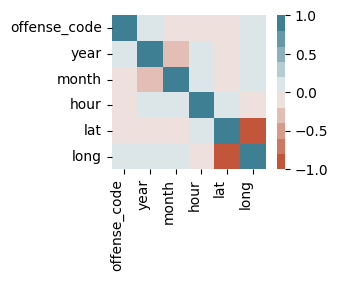

In [ ]:
corr = df.corr()
plt.figure(figsize=[3,2])
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=10), square = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

In [ ]:
df.columns

Index(['incident_number', 'offense_code', 'offense_code_group',
       'offense_description', 'district', 'reporting_area', 'shooting',
       'occurred_on_date', 'year', 'month', 'day_of_week', 'hour', 'ucr_part',
       'street', 'lat', 'long', 'location'],
      dtype='object')

In [ ]:
# 2) offense_code

print_summary('offense_code')

Number of unique values:  222
int64
3006    18783
3115    18749
3831    16323
1402    15153
802     14797
        ...  
404         1
112         1
2609        1
2606        1
1864        1
Name: offense_code, Length: 222, dtype: int64
Null values 0


In [ ]:
norm_list_values('offense_code')

3006    5.887405
3115    5.876748
3831    5.116334
1402    4.749606
802     4.638020
          ...   
404     0.000313
112     0.000313
2609    0.000313
2606    0.000313
1864    0.000313
Name: offense_code, Length: 222, dtype: float64

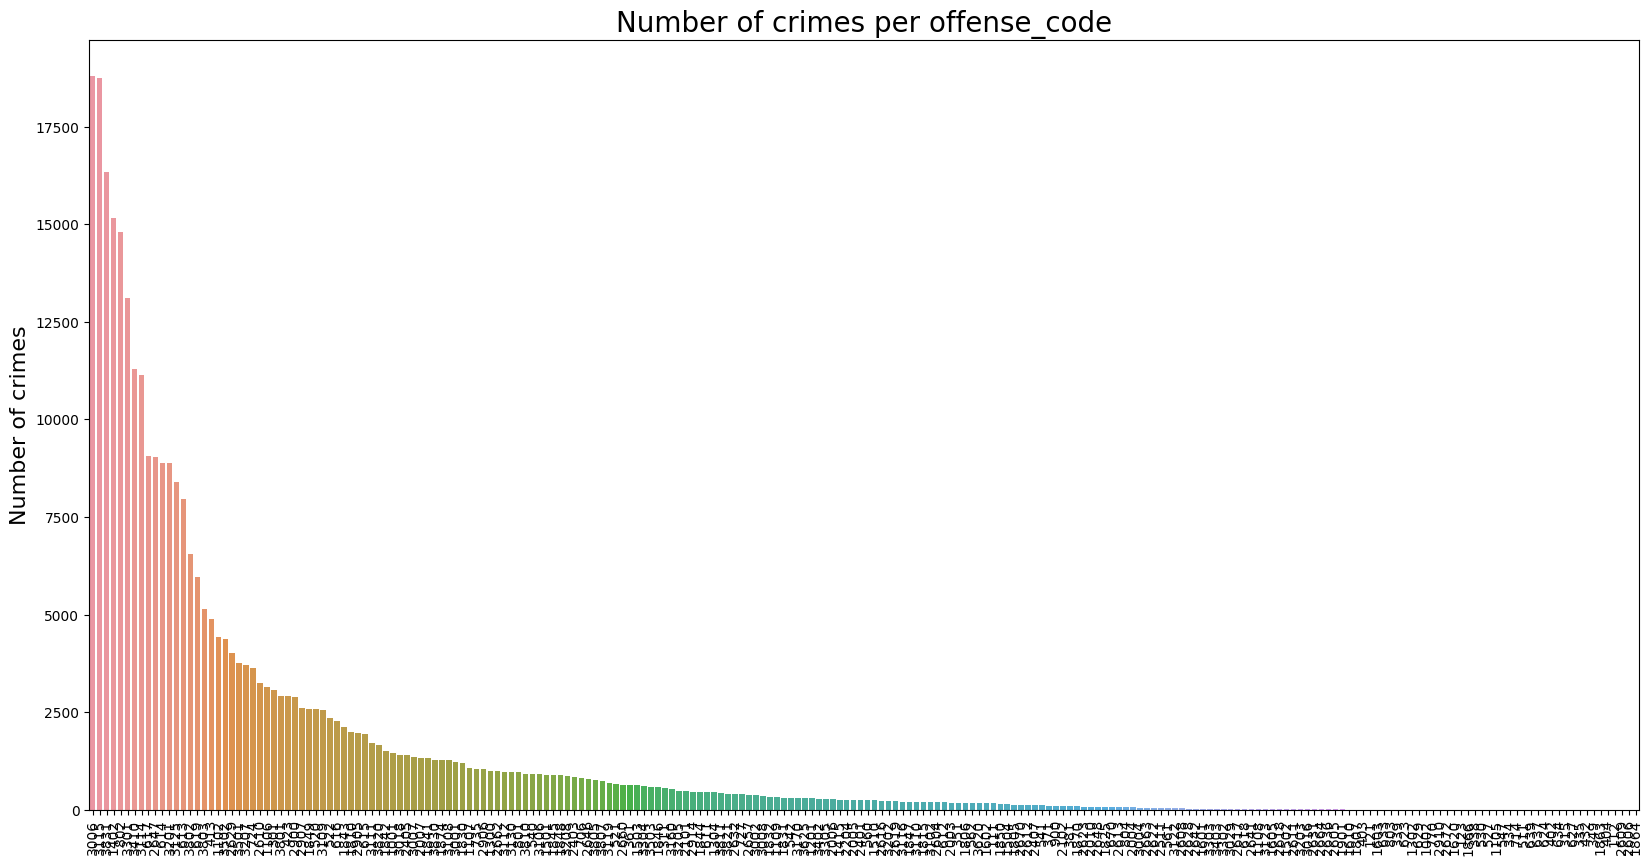

In [ ]:
ax = plot_cat_var(df,'offense_code')
plt.xticks(rotation=90);

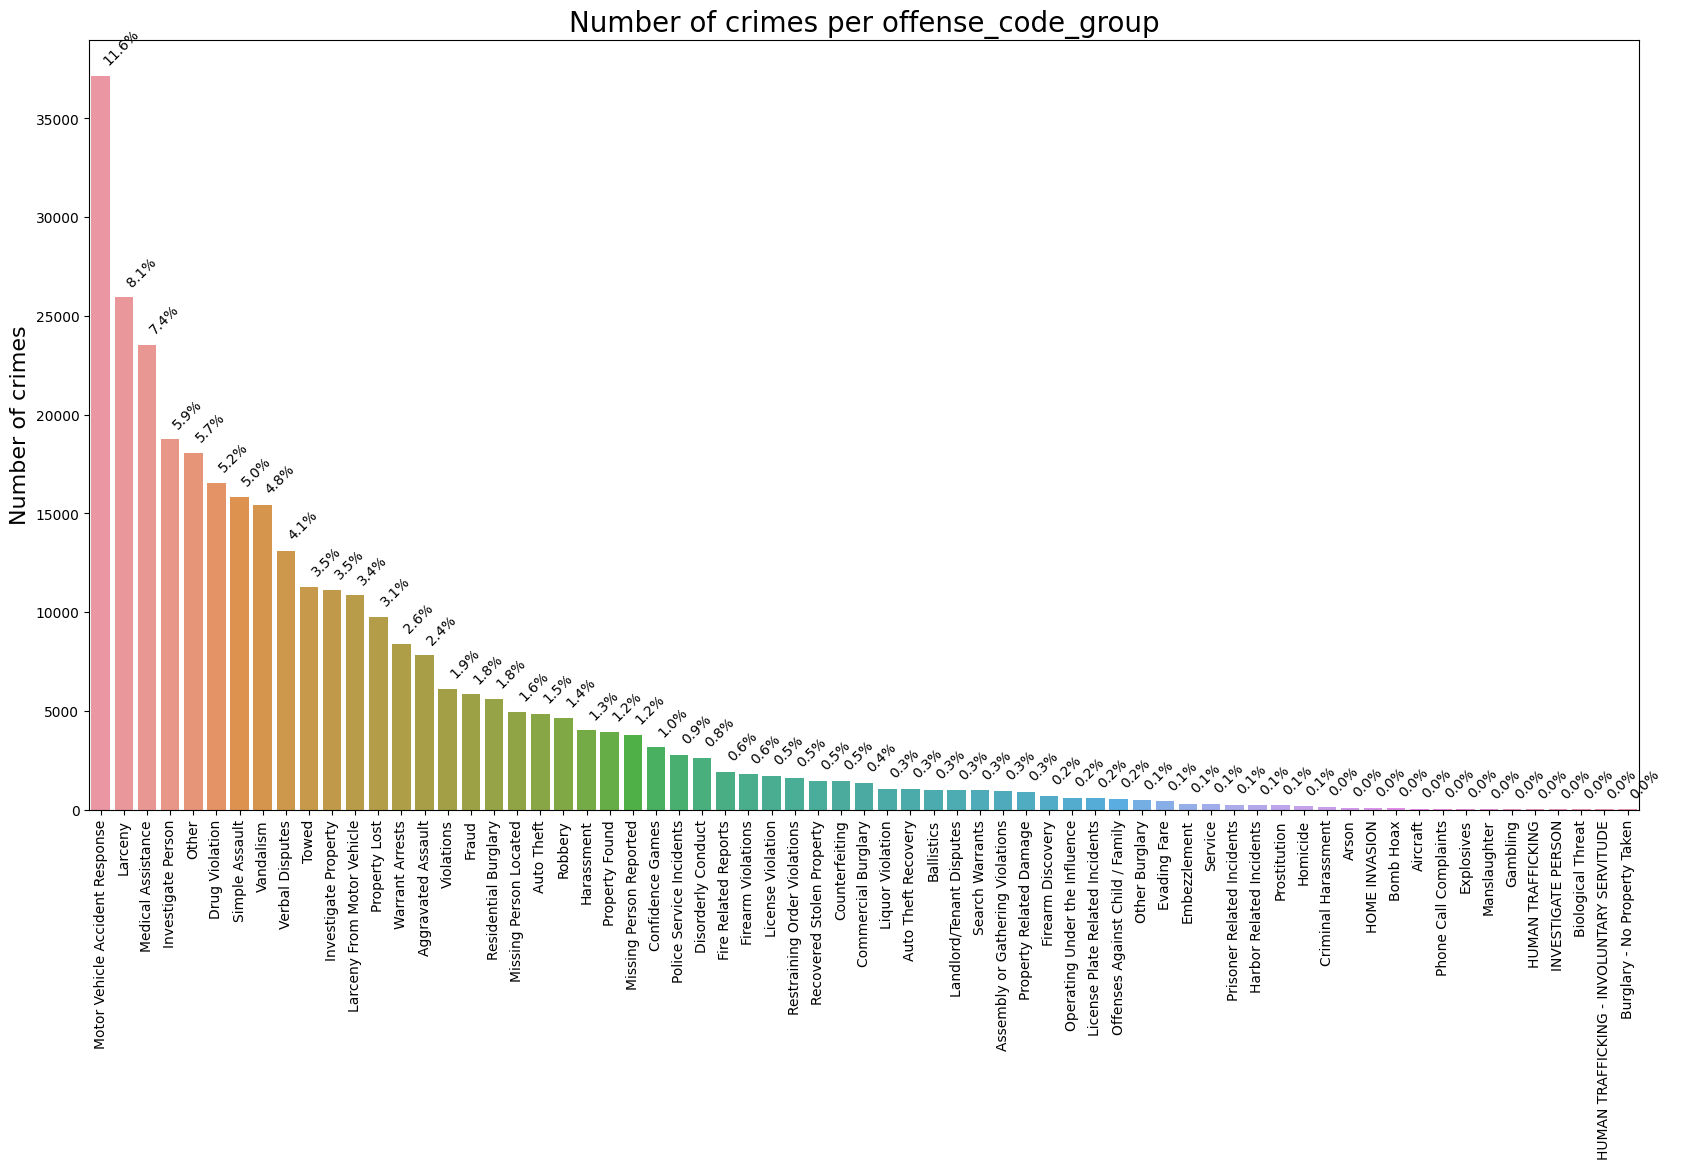

In [ ]:
ax = plot_cat_var(df,'offense_code_group', plot_perc = True)
plt.xticks(rotation=90);

In [ ]:
# 15) lat
norm_list_values('lat')

NaN          6.268238
42.348624    0.389610
42.361839    0.378639
42.284826    0.351370
42.328663    0.326608
               ...   
42.286022    0.000313
42.316501    0.000313
42.303417    0.000313
42.274797    0.000313
42.293630    0.000313
Name: lat, Length: 18179, dtype: float64

In [ ]:
df.dropna(subset= ["lat"], how ="any", inplace =True)
df.reset_index(drop=True, inplace = True)

count    299039.000000
mean         42.214368
std           2.159892
min          -1.000000
25%          42.297424
50%          42.325538
75%          42.348624
max          42.395042
Name: lat, dtype: float64


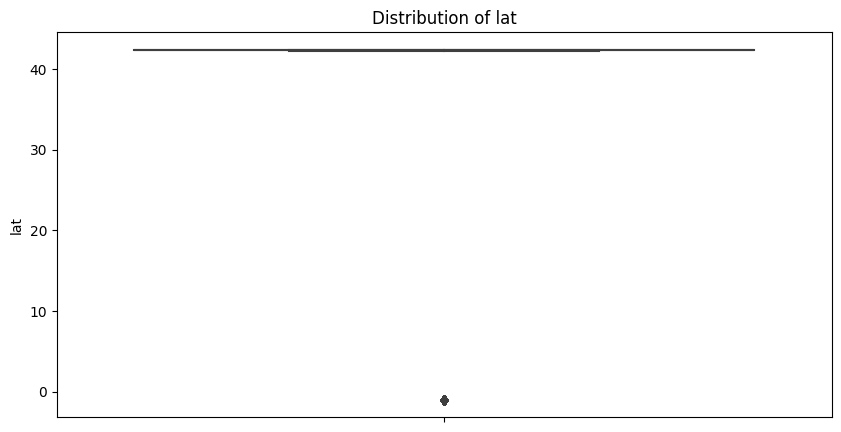

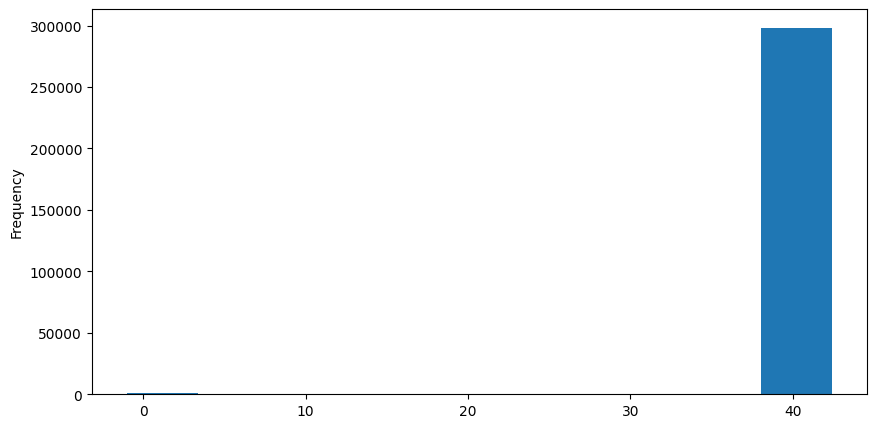

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [ ]:
plot_distr_num_var('lat', 10)

In [ ]:
df = df.drop(df[df.lat < 30].index)
df.reset_index(drop=True, inplace = True)

count    298294.000000
mean         42.322297
std           0.031882
min          42.232413
25%          42.297555
50%          42.325610
75%          42.348624
max          42.395042
Name: lat, dtype: float64


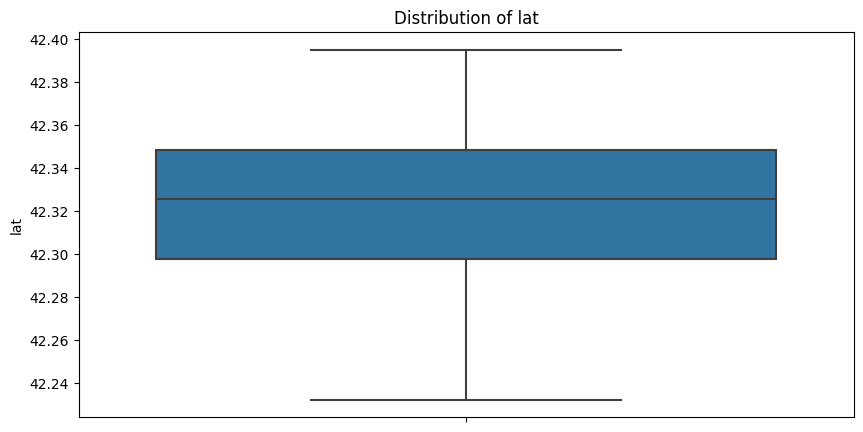

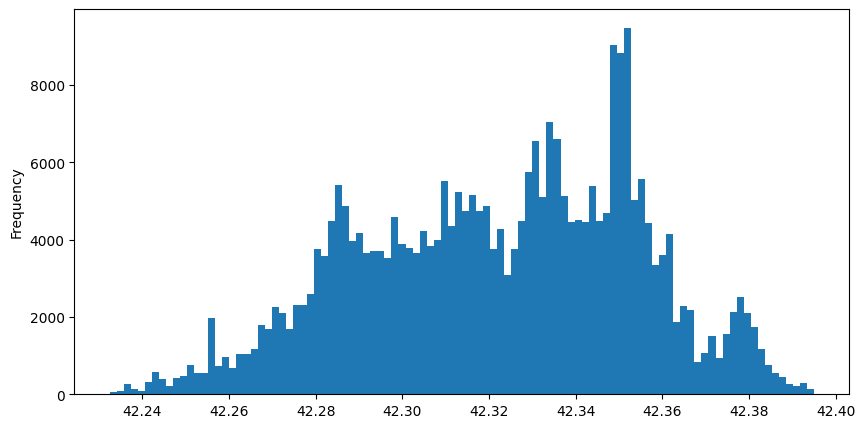

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [ ]:
plot_distr_num_var('lat', 100)

In [ ]:
# 16) long

print_summary('long')

Number of unique values:  18177
float64
-71.082776    1243
-71.059765    1208
-71.091374    1121
-71.085634    1042
-71.124019     898
              ... 
-71.133493       1
-71.137020       1
-71.085491       1
-71.050308       1
-71.050887       1
Name: long, Length: 18177, dtype: int64
Null values 0


count    298294.000000
mean        -71.082851
std           0.029772
min         -71.178674
25%         -71.097193
50%         -71.077562
75%         -71.062563
max         -70.963676
Name: long, dtype: float64


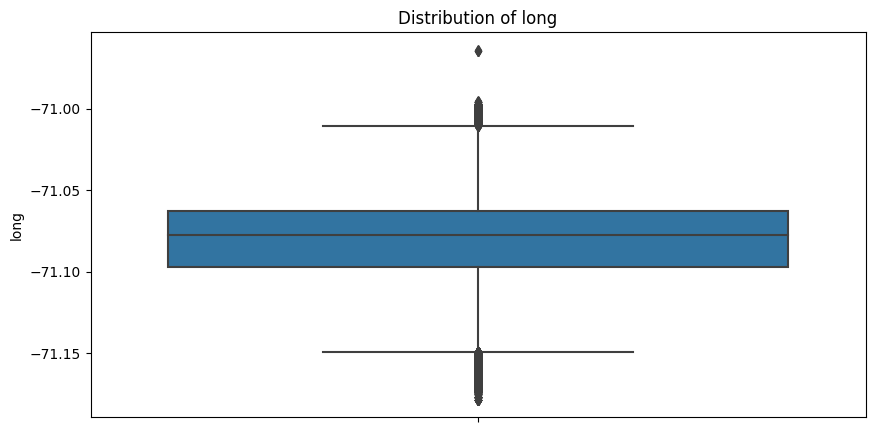

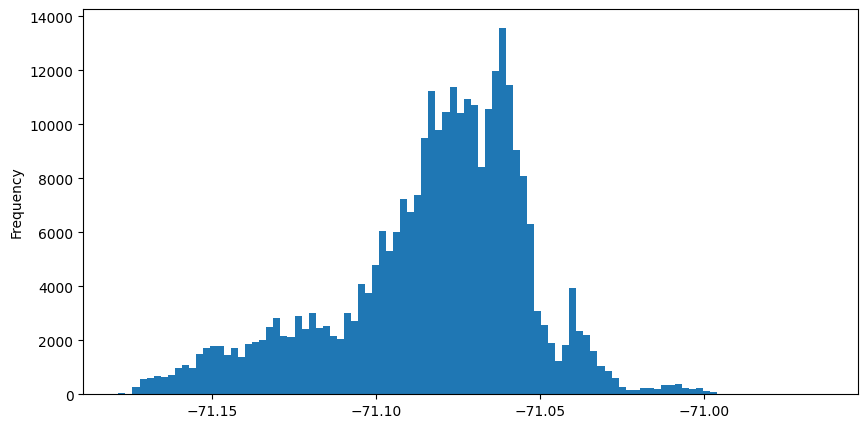

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [ ]:
plot_distr_num_var('long', 100)

In [ ]:
# 5) district

print_summary('district')

Number of unique values:  12
object
B2     46195
C11    40865
D4     38389
B3     33695
A1     32273
C6     21690
D14    19115
E18    16639
E13    16596
A7     13019
E5     12779
A15     6142
NaN      897
Name: district, dtype: int64
Null values 897


In [ ]:
df[df['district'].isna()].head(5)

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,location
15,I182070920,3006,Medical Assistance,SICK/INJURED/MEDICAL - PERSON,NaN,,NaN,9/3/2018 19:43,2018,9,Monday,19,Part Three,NaN,42.352875,-71.073830,"(42.35287456, -71.07382970)"
24,I182070906,3831,Motor Vehicle Accident Response,M/V - LEAVING SCENE - PROPERTY DAMAGE,NaN,,NaN,9/3/2018 18:20,2018,9,Monday,18,Part Three,NaN,42.283593,-71.055657,"(42.28359328, -71.05565683)"
38,I182070889,1843,Drug Violation,DRUGS - POSS CLASS B - INTENT TO MFR DIST DISP,NaN,,NaN,9/3/2018 18:05,2018,9,Monday,18,Part Two,NaN,42.306769,-71.084319,"(42.30676881, -71.08431925)"
39,I182070889,3125,Warrant Arrests,WARRANT ARREST,NaN,,NaN,9/3/2018 18:05,2018,9,Monday,18,Part Three,NaN,42.306769,-71.084319,"(42.30676881, -71.08431925)"
40,I182070889,1841,Drug Violation,DRUGS - POSS CLASS A - INTENT TO MFR DIST DISP,NaN,,NaN,9/3/2018 18:05,2018,9,Monday,18,Part Two,NaN,42.306769,-71.084319,"(42.30676881, -71.08431925)"


In [ ]:
df.dropna(subset= ['district'], how ="any", inplace =True)
df.reset_index(drop=True, inplace = True)

In [ ]:
norm_list_values('district')

B2     15.533109
C11    13.740892
D4     12.908335
B3     11.329973
A1     10.851824
C6      7.293281
D14     6.427435
E18     5.594878
E13     5.580419
A7      4.377650
E5      4.296950
A15     2.065253
Name: district, dtype: float64

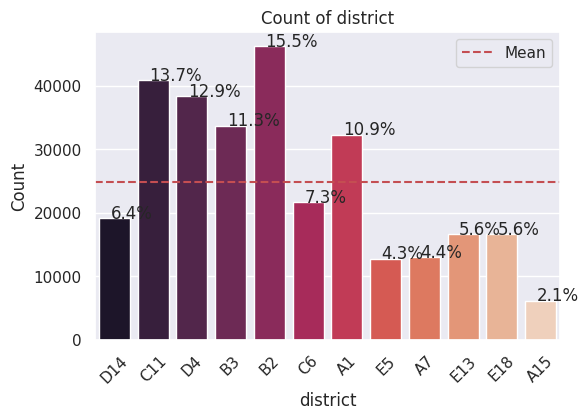

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cat_var(data, column, plot_perc=False, add_mean=False, palette='rocket', figsize=(8, 6)):
    sns.set(style="darkgrid", rc={"figure.figsize": figsize})  # Set the figure size here

    ax = sns.countplot(x=column, data=data, palette=palette)

    if plot_perc:
        total = len(data)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2 - 0.1
            y = p.get_y() + p.get_height()
            ax.annotate(percentage, (x, y), fontsize=12)

    if add_mean:
        mean_val = data[column].value_counts().mean()
        ax.axhline(y=mean_val, color='r', linestyle='--', label='Mean')
        ax.legend()

    plt.xlabel(column)
    plt.ylabel("Count")
    plt.title(f"Count of {column}")
    plt.xticks(rotation=45)

    plt.show()

# Example usage:
# Replace 'df' with your DataFrame name, and adjust figsize as needed.
plot_cat_var(df, 'district', plot_perc=True, add_mean=True, palette='rocket', figsize=(6, 4))


In [ ]:
df.reset_index(drop=True, inplace = True) # Reset index, in case I forgot to do it before when deleting rows
df_before_del_col = df.copy() # create a copy of the DF before dropping columns

In [ ]:
df.drop('incident_number', axis = 1, inplace = True)
df.drop('offense_code', axis = 1, inplace = True)
df.drop('offense_description', axis = 1, inplace = True)
df.drop('reporting_area', axis = 1, inplace = True)
df.drop('occurred_on_date', axis = 1, inplace = True)
df.drop('year', axis = 1, inplace = True)
df.drop('street', axis = 1, inplace = True)
df.drop('location', axis = 1, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297397 entries, 0 to 297396
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   offense_code_group  297397 non-null  object 
 1   district            297397 non-null  object 
 2   shooting            983 non-null     object 
 3   month               297397 non-null  int64  
 4   day_of_week         297397 non-null  object 
 5   hour                297397 non-null  int64  
 6   ucr_part            297308 non-null  object 
 7   lat                 297397 non-null  float64
 8   long                297397 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 20.4+ MB


In [ ]:
import os
lookup = {
    1: 'Night',
    2: 'Night',
    3: 'Night',
    4: 'Night',
    5: 'Night',
    6: 'Night',
    7: 'Morning',
    8: 'Morning',
    9: 'Morning',
    10: 'Morning',
    11: 'Morning',
    12: 'Morning',
    13:'Afternoon',
    14:'Afternoon',
    15:'Afternoon',
    16:'Afternoon',
    17:'Afternoon',
    18:'Afternoon',
    19:'Evening',
    20:'Evening',
    21:'Evening',
    22:'Evening',
    23:'Evening',
    0:'Evening'
}
for fname in os.listdir('.'):
    df['day_period'] = df['hour'].apply(lambda x: lookup[x])

In [ ]:
df.head()

,offense_code_group,district,shooting,month,day_of_week,hour,ucr_part,lat,long,day_period
0,Larceny,D14,NaN,9,Sunday,13,Part One,42.357791,-71.139371,Afternoon
1,Vandalism,C11,NaN,8,Tuesday,0,Part Two,42.306821,-71.060300,Evening
2,Towed,D4,NaN,9,Monday,19,Part Three,42.346589,-71.072429,Evening
3,Investigate Property,D4,NaN,9,Monday,21,Part Three,42.334182,-71.078664,Evening
4,Investigate Property,B3,NaN,9,Monday,21,Part Three,42.275365,-71.090361,Evening


In [ ]:
lookup = {
    12: 'Winter',
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Autumn',
    10: 'Autumn',
    11: 'Autumn'
}
for fname in os.listdir('.'):
    df['season'] = df['month'].apply(lambda x: lookup[x])

In [ ]:
lookup = {
    'Monday': 1,
    'Tuesday': 1,
    'Wednesday': 1,
    'Thursday': 1,
    'Friday': 1,
    'Saturday': 0,
    'Sunday': 0,
}
for fname in os.listdir('.'):
    df['weekday'] = df['day_of_week'].apply(lambda x: lookup[x])

In [ ]:
df.sample(10)

,offense_code_group,district,shooting,month,day_of_week,hour,ucr_part,lat,long,day_period,season,weekday
291634,Verbal Disputes,B2,NaN,7,Tuesday,17,Part Three,42.310900,-71.080077,Afternoon,Summer,1
137143,Larceny,B2,NaN,3,Wednesday,17,Part One,42.317756,-71.066734,Afternoon,Spring,1
288527,Property Found,A1,NaN,7,Sunday,11,Part Three,42.356784,-71.066708,Morning,Summer,0
250332,License Violation,A1,NaN,12,Tuesday,23,Part Three,42.365425,-71.059576,Evening,Winter,1
129823,Medical Assistance,A1,NaN,4,Thursday,15,Part Three,42.362429,-71.060549,Afternoon,Spring,1
131942,Verbal Disputes,B2,NaN,4,Wednesday,11,Part Three,42.318979,-71.079647,Morning,Spring,1
172966,Motor Vehicle Accident Response,D4,NaN,10,Tuesday,12,Part Three,42.347106,-71.079756,Morning,Autumn,1
72838,Motor Vehicle Accident Response,C11,NaN,11,Sunday,15,Part Three,42.280343,-71.054745,Afternoon,Autumn,0
129949,Aggravated Assault,A1,NaN,4,Thursday,8,Part One,42.363397,-71.070224,Morning,Spring,1
234772,Auto Theft,E18,NaN,2,Saturday,1,Part One,42.256216,-71.124019,Night,Winter,0


In [ ]:
df.drop('month', axis = 1, inplace = True)
df.drop('hour', axis = 1, inplace = True)
df.drop('day_of_week', axis = 1, inplace = True)

In [ ]:
df.to_csv('df_crimes_cleaned.csv')

In [ ]:
df = pd.read_csv('df_crimes_cleaned.csv', sep=",", index_col=0)
df.head()

,offense_code_group,district,shooting,ucr_part,lat,long,day_period,season,weekday
0,Larceny,D14,NaN,Part One,42.357791,-71.139371,Afternoon,Autumn,0
1,Vandalism,C11,NaN,Part Two,42.306821,-71.060300,Evening,Summer,1
2,Towed,D4,NaN,Part Three,42.346589,-71.072429,Evening,Autumn,1
3,Investigate Property,D4,NaN,Part Three,42.334182,-71.078664,Evening,Autumn,1
4,Investigate Property,B3,NaN,Part Three,42.275365,-71.090361,Evening,Autumn,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297397 entries, 0 to 297396
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   offense_code_group  297397 non-null  object 
 1   district            297397 non-null  object 
 2   shooting            983 non-null     object 
 3   ucr_part            297308 non-null  object 
 4   lat                 297397 non-null  float64
 5   long                297397 non-null  float64
 6   day_period          297397 non-null  object 
 7   season              297397 non-null  object 
 8   weekday             297397 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 22.7+ MB


In [ ]:
list_obj = list(df.select_dtypes(include=['object']).columns) # list of object columns
# encode all object variables at once
for i in list_obj:
    dummy_var = pd.get_dummies(df[i], sparse = False, prefix = i) # One hot encoding with get_dummies
    df = df.join(dummy_var)
    df = df.drop(i, axis = 1)
    del dummy_var

In [ ]:
df.head()

,lat,long,weekday,offense_code_group_Aggravated Assault,offense_code_group_Aircraft,offense_code_group_Arson,offense_code_group_Assembly or Gathering Violations,offense_code_group_Auto Theft,offense_code_group_Auto Theft Recovery,offense_code_group_Ballistics,...,ucr_part_Part Three,ucr_part_Part Two,day_period_Afternoon,day_period_Evening,day_period_Morning,day_period_Night,season_Autumn,season_Spring,season_Summer,season_Winter
0,42.357791,-71.139371,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,42.306821,-71.060300,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
2,42.346589,-71.072429,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
3,42.334182,-71.078664,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
4,42.275365,-71.090361,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0


In [ ]:
df = pd.read_csv('df_crimes_cleaned.csv', sep=",", index_col=0)
df.head()

,offense_code_group,district,shooting,ucr_part,lat,long,day_period,season,weekday
0,Larceny,D14,NaN,Part One,42.357791,-71.139371,Afternoon,Autumn,0
1,Vandalism,C11,NaN,Part Two,42.306821,-71.060300,Evening,Summer,1
2,Towed,D4,NaN,Part Three,42.346589,-71.072429,Evening,Autumn,1
3,Investigate Property,D4,NaN,Part Three,42.334182,-71.078664,Evening,Autumn,1
4,Investigate Property,B3,NaN,Part Three,42.275365,-71.090361,Evening,Autumn,1


In [ ]:
print('Subset of the total data', str(df.offense_code_group[df.offense_code_group =='Larceny'].value_counts()))
df_L=df[df.offense_code_group =='Larceny']

Subset of the total data Larceny    25078
Name: offense_code_group, dtype: int64


In [ ]:
districts = df_L.district

In [ ]:
df_L.drop('offense_code_group', axis = 1, inplace = True)
df_L.drop('district', axis = 1, inplace = True)
df_L.drop('shooting', axis = 1, inplace = True)
df_L.drop('ucr_part', axis = 1, inplace = True)
df_L.drop('day_period', axis = 1, inplace = True)
df_L.drop('season', axis = 1, inplace = True)
df_L.drop('weekday', axis = 1, inplace = True)

<ipython-input-64-4d393a24caeb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_L.drop('offense_code_group', axis = 1, inplace = True)
<ipython-input-64-4d393a24caeb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_L.drop('district', axis = 1, inplace = True)
<ipython-input-64-4d393a24caeb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_L.drop('shooting', axis = 1, inplace = True)
<ipython-input-64-4d393a24caeb>:4: Setting

In [ ]:
data = df_L.sample(frac=0.95, random_state=17)
data_unseen = df_L.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (23824, 2)
Unseen Data For Predictions: (1254, 2)


In [ ]:
data.head()

,lat,long
0,42.275313,-71.115878
1,42.351031,-71.063733
2,42.319285,-71.050272
3,42.333112,-71.072764
4,42.328491,-71.081213


In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.to_numpy())
scaled_data[0]

array([-2.03179585, -1.27455509])

In [ ]:
import numpy as np
from numpy.linalg import norm

from sklearn.metrics import pairwise_distances, adjusted_mutual_info_score
from sklearn.datasets import make_classification
from sklearn.cluster import SpectralClustering
import sklearn.svm as svm
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import networkx as nx
import community
import community.community_louvain as community_louvain

In [ ]:
df

,offense_code_group,district,shooting,ucr_part,lat,long,day_period,season,weekday
0,Larceny,D14,NaN,Part One,42.357791,-71.139371,Afternoon,Autumn,0
1,Vandalism,C11,NaN,Part Two,42.306821,-71.060300,Evening,Summer,1
2,Towed,D4,NaN,Part Three,42.346589,-71.072429,Evening,Autumn,1
3,Investigate Property,D4,NaN,Part Three,42.334182,-71.078664,Evening,Autumn,1
4,Investigate Property,B3,NaN,Part Three,42.275365,-71.090361,Evening,Autumn,1
...,...,...,...,...,...,...,...,...,...
297392,Warrant Arrests,D4,NaN,Part Three,42.336951,-71.085748,Afternoon,Summer,0
297393,Homicide,E18,NaN,Part One,42.255926,-71.123172,Afternoon,Summer,1
297394,Warrant Arrests,E18,NaN,Part Three,42.255926,-71.123172,Afternoon,Summer,1
297395,Warrant Arrests,E13,NaN,Part Three,42.302333,-71.111565,Evening,Spring,1


In [ ]:
clustering_data = df['offense_code_group']
clustering_data

0                      Larceny
1                    Vandalism
2                        Towed
3         Investigate Property
4         Investigate Property
                  ...         
297392         Warrant Arrests
297393                Homicide
297394         Warrant Arrests
297395         Warrant Arrests
297396         Warrant Arrests
Name: offense_code_group, Length: 297397, dtype: object

In [ ]:
# Create an empty graph
graph = nx.Graph()

# Add nodes to the graph
graph.add_nodes_from(data.index)

In [ ]:
pip install kmodes

In [ ]:
import numpy as np
import pandas as pd
from kmodes.kprototypes import KPrototypes

import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [ ]:
df_array = scaled_data
df_array

array([[-2.03179585, -1.27455509],
       [ 0.63148185,  0.64195916],
       [-0.48513524,  1.13672545],
       ...,
       [-0.60177923,  0.54935101],
       [ 0.66326338,  0.76131305],
       [-0.21490329,  0.02500637]])

In [ ]:
from pandas.core.arrays import categorical
kproto = KPrototypes(n_clusters=3, verbose=2, max_iter=20)
clusters = kproto.fit_predict(df_array, categorical=[1])
label = kproto.fit_predict(df_array,categorical=[1])

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 4172, ncost: 14828.117191767544
Run: 1, iteration: 2/20, moves: 715, ncost: 14748.55519068809
Run: 1, iteration: 3/20, moves: 300, ncost: 14739.088212467603
Run: 1, iteration: 4/20, moves: 139, ncost: 14737.593382399898
Run: 1, iteration: 5/20, moves: 80, ncost: 14737.094285901967
Run: 1, iteration: 6/20, moves: 7, ncost: 14737.091247412192
Run: 1, iteration: 7/20, moves: 0, ncost: 14737.091247412192
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/20, moves: 1788, ncost: 15049.921449021502
Run: 2, iteration: 2/20, moves: 1694, ncost: 14771.728221611298
Run: 2, iteration: 3/20, moves: 608, ncost: 14741.728828327925
Run: 2, iteration: 4/20, moves: 193, ncost: 14738.546488166961
Run: 2, iteration: 5/20, moves: 126, ncost: 14737.273325458142
Run: 2, ite

In [ ]:
cluster_dict=[]
for c in clusters:
  cluster_dict.append(c)

In [ ]:
cluster_dict

[0,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 0,
 2,
 1,
 2,
 0,
 2,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 1,
 0,
 2,
 2,
 1,
 2,
 2,
 1,
 0,
 0,
 1,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 2,
 2,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 0,
 1,
 2,
 1,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 1,
 1,
 0,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 1,
 0,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 0,
 1,
 1,
 2,
 0,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 0,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 0,
 2,
 1,
 0,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 1,
 0,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 1,


In [ ]:
data['cluster'] = cluster_dict

In [ ]:
data

,lat,long,cluster
0,42.275313,-71.115878,0
1,42.351031,-71.063733,2
2,42.319285,-71.050272,1
3,42.333112,-71.072764,1
4,42.328491,-71.081213,1
...,...,...,...
23819,42.348776,-71.096068,2
23820,42.344423,-71.098331,2
23821,42.315969,-71.066253,1
23822,42.351935,-71.060486,2


In [ ]:
data[data['cluster']==0]

,lat,long,cluster
0,42.275313,-71.115878,0
10,42.277793,-71.099172,0
14,42.298489,-71.063133,0
17,42.281871,-71.087512,0
24,42.299197,-71.060470,0
...,...,...,...
23778,42.284106,-71.046089,0
23792,42.289278,-71.075815,0
23800,42.283147,-71.113742,0
23802,42.272820,-71.065258,0


In [ ]:
data[data['cluster']==1]

,lat,long,cluster
2,42.319285,-71.050272,1
3,42.333112,-71.072764,1
4,42.328491,-71.081213,1
6,42.311538,-71.066233,1
9,42.324451,-71.058107,1
...,...,...,...
23811,42.337630,-71.107724,1
23813,42.328535,-71.082139,1
23816,42.334018,-71.076381,1
23821,42.315969,-71.066253,1


In [ ]:
data[data['cluster']==2]

,lat,long,cluster
1,42.351031,-71.063733,2
5,42.349802,-71.078410,2
7,42.375449,-71.067106,2
8,42.353325,-71.057276,2
11,42.352198,-71.164304,2
...,...,...,...
23817,42.348406,-71.086883,2
23818,42.350809,-71.081436,2
23819,42.348776,-71.096068,2
23820,42.344423,-71.098331,2


<Axes: >

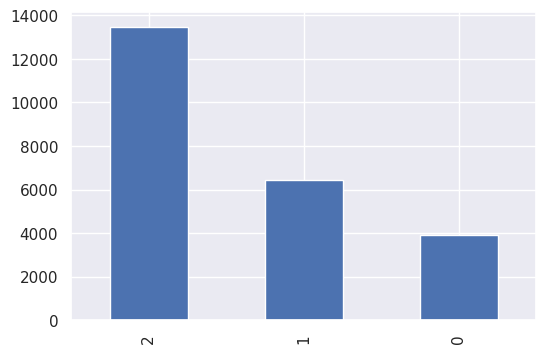

In [ ]:
data['cluster'].value_counts().plot(kind='bar')

In [ ]:
data.groupby(['cluster']).mean()

,lat,long
cluster,,
0,42.280895,-71.095226
1,42.323121,-71.079393
2,42.352921,-71.078014


In [ ]:
print(label)

[2 0 1 ... 1 0 1]


In [ ]:
kproto = KPrototypes(n_clusters=3, verbose=2, max_iter=20)
clusters = kproto.fit_predict(scaled_data, categorical=[1])
label = kproto.fit_predict(scaled_data,categorical=[1])


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 3472, ncost: 15541.73080629964
Run: 1, iteration: 2/20, moves: 1780, ncost: 15277.877660262282
Run: 1, iteration: 3/20, moves: 1307, ncost: 15171.981022865588
Run: 1, iteration: 4/20, moves: 850, ncost: 15136.48941158812
Run: 1, iteration: 5/20, moves: 292, ncost: 15131.816486860202
Run: 1, iteration: 6/20, moves: 86, ncost: 15131.177833826094
Run: 1, iteration: 7/20, moves: 54, ncost: 15131.032916956598
Run: 1, iteration: 8/20, moves: 19, ncost: 15131.018016295788
Run: 1, iteration: 9/20, moves: 2, ncost: 15131.017837168378
Run: 1, iteration: 10/20, moves: 0, ncost: 15131.017837168378
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/20, moves: 4258, ncost: 16765.842322406435
Run: 2, iteration: 2/20, moves: 2486, ncost: 16280.343180533831
Run: 2, ite

In [ ]:
data['cluster_group_kprototype'] = label

In [ ]:
plot_clusters('cluster_group_kprototype')
plot_cluster_info('cluster_group_kprototype')

count    23824.000000
mean         0.892335
std          0.650246
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: cluster_group_kprototype, dtype: float64
Number of clusters=  3


In [ ]:
import numpy as np
import pandas as pd
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# Assuming you have already fitted K-Prototypes and added cluster labels to the 'data' DataFrame

# Calculate Silhouette Score
silhouette_avg = silhouette_score(df_array, label)

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(df_array, label)

# Calculate Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(df_array, label)

# Print the scores
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")


Silhouette Score: 0.2601979070982446
Davies-Bouldin Index: 1.374989984107285
Calinski-Harabasz Index: 9973.813616873382


Silhouette Score: 0.2601979070982446
Davies-Bouldin Index: 1.374989984107285
Calinski-Harabasz Index: 9973.813616873382


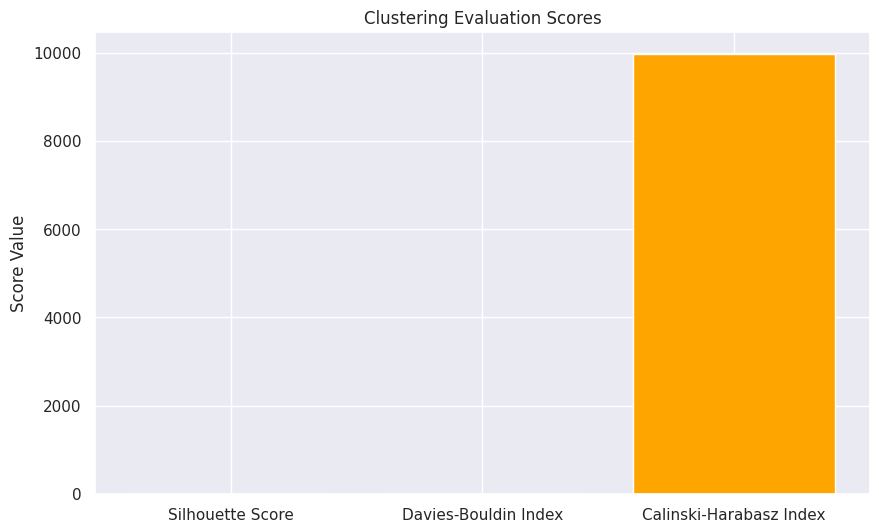

In [ ]:
import numpy as np
import pandas as pd
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# Assuming you have already fitted K-Prototypes and added cluster labels to the 'data' DataFrame

# Calculate Silhouette Score
silhouette_avg = silhouette_score(df_array, label)

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(df_array, label)

# Calculate Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(df_array, label)

# Print the scores
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Plot the scores
scores = [silhouette_avg, davies_bouldin, calinski_harabasz]
score_names = ["Silhouette Score", "Davies-Bouldin Index", "Calinski-Harabasz Index"]

plt.figure(figsize=(10, 6))
plt.bar(score_names, scores, color=['blue', 'green', 'orange'])
plt.title("Clustering Evaluation Scores")
plt.ylabel("Score Value")
plt.show()
